In [60]:
import matplotlib.pyplot as plt
import numpy as np

In [61]:
class EqLogic:
        def __init__(self, price_feed, dt):
                self.price_feed = price_feed
                self.dt = dt
                self.precision = 1e18
                self.balances_usdc=1
                self.balances_usdt=1
                self.balances_dai=1
        
        def increment_usdc(self):
                self.balances_usdc += 1

        def increment_usdt(self):
                self.balances_usdt += 1

        def increment_dai(self):
                self.balances_dai += 1

        
        def _get_system_allocation(self,_p1,_p2,_p3):
                p1 = _p1
                p2 = _p2
                p3 = _p3

                if p1 > self.dt:
                        if p2 > self.dt and p3 > self.dt:
                                return 8e3, 1e3, 1e3
                        elif p2 > self.dt and p3 < self.dt:
                                return 9e3, 1e3, 0
                        elif p2 < self.dt and p3 > self.dt:
                                return 9e3, 0, 1e3
                        else:
                                return 10e3, 0, 0
                else:
                        raise Exception("VAULT: Deposits Halted")
        
        def _calc_eq(self, cr1, cr2, cr3):
                return (self.mod_sub(cr1) + self.mod_sub(cr2) + self.mod_sub(cr3)) / 3 

        def mod_sub(self, a):
                if a != 0:
                        return a - self.precision if a > self.precision else self.precision - a
                else:
                        return 0

In [62]:
def deposit(_usdc_amt, _usdt_amt, _dai_amt):
    eq_logic = EqLogic(price_feed="0x...", dt=100)

    usdc_amt = _usdc_amt
    usdt_amt = _usdt_amt
    dai_amt = _dai_amt
    eq_th = 1.5e18

    a1, a2, a3 = eq_logic._get_system_allocation(usdc_amt, usdt_amt, dai_amt)
    print(a1)
    t_alloc = a1 + a2 + a3
    balances = a1 + a2 + a3
    tvl_old = eq_logic.balances_usdc+eq_logic.balances_usdt+eq_logic.balances_dai

    tvl_new = tvl_old + usdc_amt + usdt_amt + dai_amt
    cr = []

    cr.append( (eq_logic.balances_usdc * t_alloc * eq_logic.precision) / (a1 * tvl_old) if a1 != 0 else 0)
    cr.append( (eq_logic.balances_usdt * t_alloc * eq_logic.precision) / (a2 * tvl_old) if a2 != 0 else 0)
    cr.append((eq_logic.balances_dai * t_alloc * eq_logic.precision) / (a3 * tvl_old) if a3 != 0 else 0)

    old_eq=eq_logic._calc_eq(cr[0], cr[1], cr[2])

    cr.append(  ((eq_logic.balances_usdc+usdc_amt) * t_alloc * eq_logic.precision) / (a1 * tvl_new) if a1 != 0 else 0)
    cr.append( ((eq_logic.balances_usdt+usdt_amt) * t_alloc * eq_logic.precision) / (a2 * tvl_new) if a2 != 0 else 0)
    cr.append( ((eq_logic.balances_dai+dai_amt) * t_alloc * eq_logic.precision) / (a3 * tvl_new) if a3 != 0 else 0)

    new_eq=eq_logic._calc_eq(cr[3], cr[4], cr[5])

    if (new_eq <= old_eq or new_eq < eq_th):
        eq_logic.increment_usdc()
        eq_logic.increment_usdt()
        eq_logic.increment_dai()
    else:
        raise Exception("HUB::Deposit Not Allowed")

    return old_eq, new_eq, a1, a2, a3, usdc_amt, usdt_amt, dai_amt
deposit(100000,1,1)

10000.0


(2.2222222222222224e+17, 13332666699989.334, 10000.0, 0, 0, 100000, 1, 1)

In [63]:
x= []
x.append(deposit(10000,1500,2000))
x.append(deposit(9000,0,2000))
x.append(deposit(10500,3500,0))
x


8000.0
9000.0
9000.0


[(1.75e+18, 2.2256165296600755e+17, 8000.0, 1000.0, 1000.0, 10000, 1500, 2000),
 (9.876543209876545e+17,
  3.0321696776300064e+17,
  9000.0,
  0,
  1000.0,
  9000,
  0,
  2000),
 (9.876543209876545e+17,
  5.556481283111291e+17,
  9000.0,
  1000.0,
  0,
  10500,
  3500,
  0)]

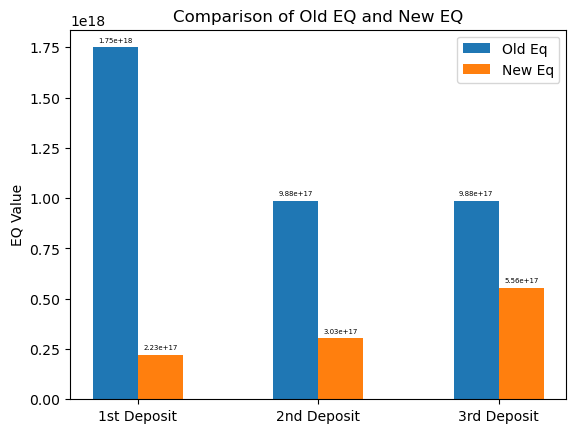

In [64]:
values0=[item[0] for item in x]
values1=[item[1] for item in x]
values0
fig, ax = plt.subplots()
labels = ['1st Deposit', '2nd Deposit', '3rd Deposit']
z = np.arange(len(labels))
width = 0.25
rec1=ax.bar(z-width/2, values0, width, label="Old Eq")
rec2=ax.bar(z+width/2, values1, width, label="New Eq")

ax.set_ylabel('EQ Value')
ax.set_title('Comparison of Old EQ and New EQ')
ax.set_xticks(z)
ax.set_xticklabels(labels)
ax.legend()
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2e}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=5)

add_labels(rec1)
add_labels(rec2)

plt.show()

In [65]:
values1

[2.2256165296600755e+17, 3.0321696776300064e+17, 5.556481283111291e+17]

<Figure size 2000x1000 with 0 Axes>

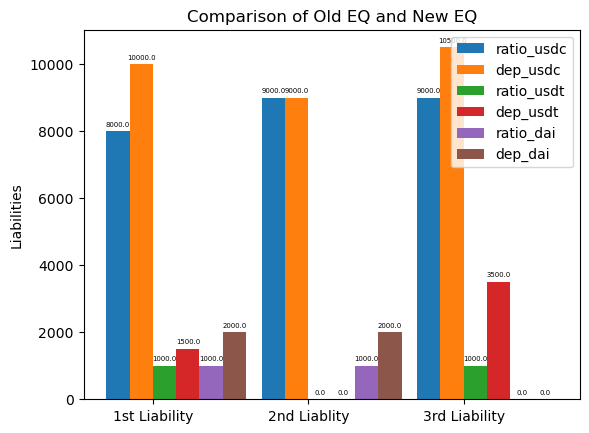

In [66]:
values2=[item[2] for item in x]
values3=[item[3] for item in x]
values4=[item[4] for item in x]
values5=[item[5] for item in x]
values6=[item[6] for item in x]
values7=[item[7] for item in x]

plt.figure(figsize=(20, 10))  
fig, ax = plt.subplots()
labels = ['1st Liability', '2nd Liablity', '3rd Liability']
z = np.arange(len(labels))
width = 0.15

rec3=ax.bar(z-3*width/2, values2, width, label="ratio_usdc")
rec4=ax.bar(z-width/2, values5, width, label="dep_usdc")
rec5=ax.bar(z + width/2, values3, width, label="ratio_usdt")
rec6=ax.bar(z + 3*width/2, values6, width, label="dep_usdt")
rec7=ax.bar(z + 5*width/2, values4, width, label="ratio_dai")
rec8=ax.bar(z + 7*width/2, values7, width, label="dep_dai")

ax.set_ylabel('Liabilities')
ax.set_title('Comparison of Old EQ and New EQ')

ax.set_xticks(z)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=5)

add_labels(rec3)
add_labels(rec4)
add_labels(rec5)
add_labels(rec6)
add_labels(rec7)
add_labels(rec8)

plt.show()

In [68]:
values5

[10000, 9000, 10500]